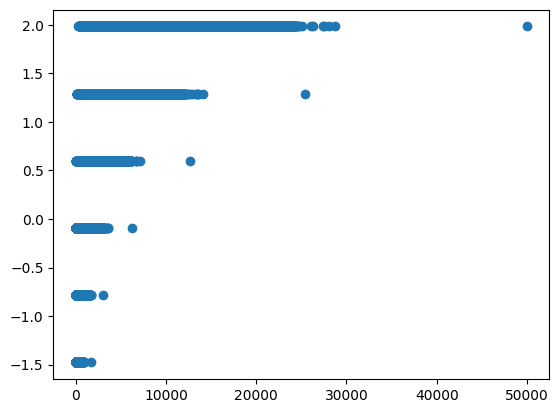

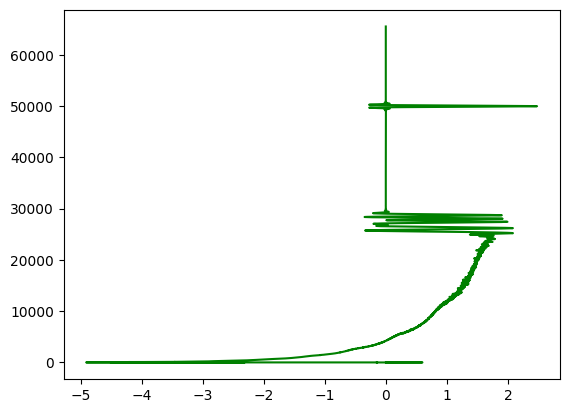

-2.587564937515131e-08


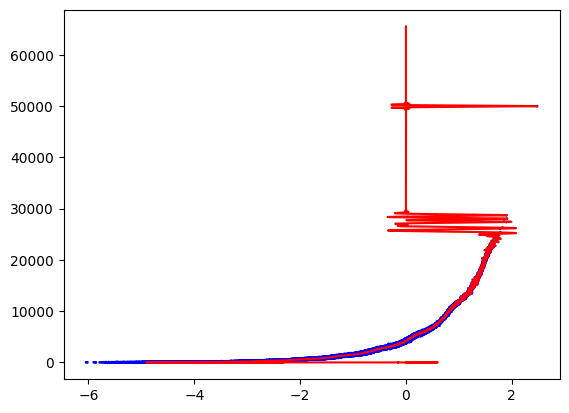

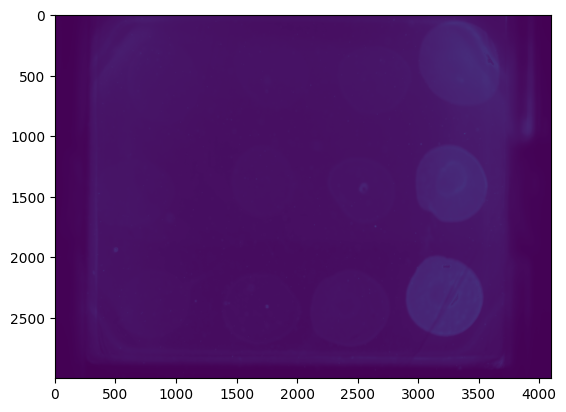

In [ ]:
from PIL import Image
import numpy as np
import random, glob, cupy
from matplotlib import pyplot as plt
import cupyx.scipy.sparse as cusp
import scipy.sparse as sp
import cupyx.scipy.sparse.linalg as cusplin
from datetime import datetime

Rev = "251114-02"

def pixelValues(tif_paths, exposures, pixels):
    """
    Inputs:
        tif_paths: tif filepaths of imgages files with different exposures
        exposures: exposure in seconds for each images
        pixels: number of pixels to be sampled from each image
        length of tif files and exposures should match
    Outputs:
    	Z: Returns a pixel value matrix where each row is a flattened image and 
    	each column is exposure bracket
        B: Matrix with the same shape as Z with Log exposure that corresponds to 
        every pizel value in Z
		raw_images: raw image data in the flatterned form
    """
    # tif_paths = glob.glob(os.path.join(folder, "*.tif"))
    pixel_vec = sorted(random.sample(range(0, 12288000), pixels))
    rows = len(tif_paths)
    # image_array = np.asarray(Image.open(tif_paths[0]), dtype = np.float32).shape
    # columns = image_array[0]*image_array[1]
    Z = np.zeros((pixels, rows), dtype = np.float32)
    B = np.zeros((pixels, rows), dtype = np.float32)
    raw_images = []
    for i in range(len(tif_paths)):
        raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
        Z[:, i] = raw_img[pixel_vec]
        B[:, i] = np.log(exposures[i])
        raw_images.append(raw_img)
    return Z, B, np.array(raw_images).astype(int)

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives maximum weightage to the pixel values in the middle than the extreme ones
    """
    # return Z if Z <= 32767 else (65535-Z)
    return (Z/32767) if Z <= 32767 else ((65535-Z)/32767)

def gsolve_cusp(Z, B, l, w):
    """
    From paper: https://icg.gwu.edu/sites/g/files/zaxdzs6126/files/downloads/Recovering%20high%20dynamic%20range%20radiance%20maps%20from%20photographs.pdf
    """
    n = 65536
    Z = Z.astype(int)
    A = sp.lil_matrix((Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0]), dtype=float)
    b = sp.lil_matrix((A.shape[0], 1), dtype=float)

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w(Z[i, j] + 1)
            A[k, Z[i, j] + 1] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[i, j]
            k = k + 1

    A[k, 32767] = 1
    k = k + 1

    for i in range(n-1):
        A[k, i] = l * w(i+1)
        A[k, i+1] = -2 * l * w(i+1)
        A[k, i+2] = l * w(i+1)
        k = k + 1
    gpu_A = cusp.csc_matrix(A);	gpu_b = cusp.csr_matrix(b)
    x = cusplin.lsmr(gpu_A, gpu_b.toarray(), atol=1e-09, btol=1e-09)
    # x = sp.linalg.lsqr(A, b.toarray())
    # x = sp.linalg.lsmr(A, b.toarray(), atol=1e-09, btol=1e-09)
    g = x[0][0:n]
    lE = x[0][n:len(x[0])]

    return g.get(), lE.get(), x

tif_paths = glob.glob("2025*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
Z, B, raw_imgs = pixelValues(tif_paths, expos, 15000)

plt.scatter(Z,B)
plt.show()

g, lE, x = gsolve_cusp(Z, B, 2.5, w)

plt.plot(g, np.arange(65536), 'g')
plt.show()
print(g[32767])

lE_t_dt = np.zeros_like(Z)
for i in range(Z.shape[1]):
	lE_t_dt [:, i] = expos[i]*np.exp(lE)

plt.scatter(np.log(lE_t_dt.flatten()), Z.flatten(), s=1, marker = "o",facecolors='none', edgecolors='blue')
plt.plot(g, np.arange(65536), 'r')
plt.show()

HDR_img = np.zeros((len(raw_imgs[0]), 1), dtype=np.float32)
num = 0;	den = 0
for i in range(raw_imgs.shape[1]):
    for j in range(raw_imgs.shape[0]):
        num = num + w(raw_imgs[j, i]) * (g[raw_imgs[j,i]] - np.log(expos[j]))
        den = den + w(raw_imgs[j, i])
        if j == raw_imgs.shape[0]-1:
            HDR_img[i, 0] = np.exp(num / den)
            num = 0;	den = 0

HDR_img = HDR_img * (2**12)
HDR_pic = HDR_img.reshape((3000, 4096))
HDR_pic = HDR_pic.round().astype(np.uint16)
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M")
HDR_pic1.save(f"HDR_{Rev}_{timestamp_str}.tif")

Time1: 0.9905805587768555


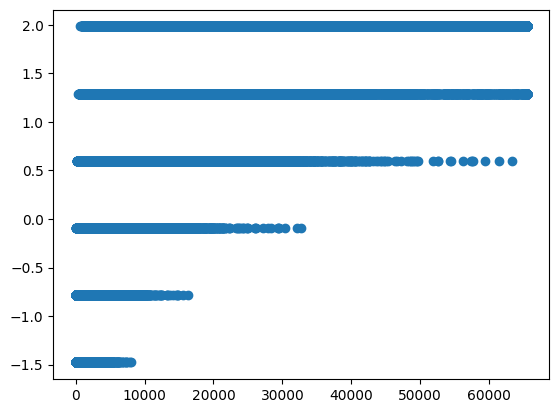

Time2: 44.07065987586975


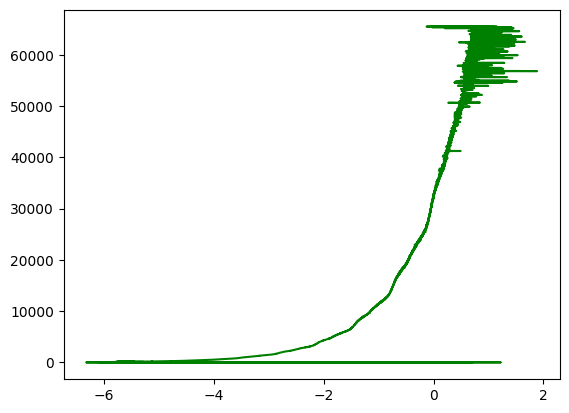

Value of g at 32767 is: 4.601834964761841e-06


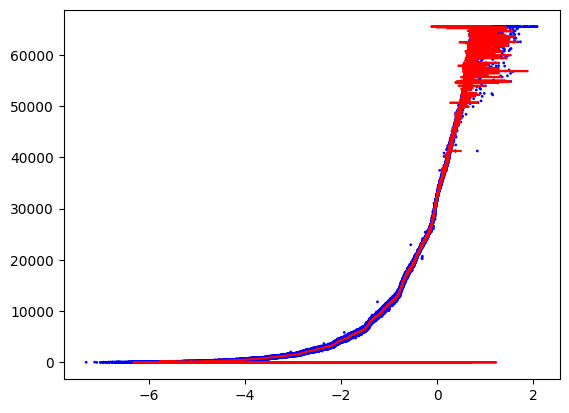

Time3: 45.58026647567749
Time4: 46.938658714294434


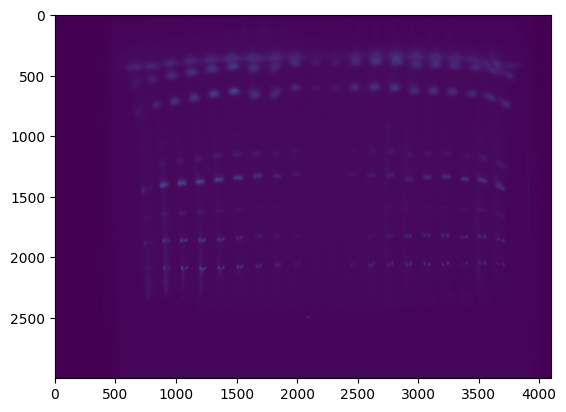

Time5: 48.35851860046387


In [1]:
from PIL import Image
import numpy as np
import random, glob, time, cupy
from matplotlib import pyplot as plt
import cupyx.scipy.sparse as cusp
import scipy.sparse as sp
import cupyx.scipy.sparse.linalg as cusplin
from datetime import datetime

def pixelValues(tif_paths, exposures, pixels):
    """
    Inputs:
        tif_paths: tif filepaths of imgages files with different exposures
        exposures: exposure in seconds for each images
        pixels: number of pixels to be sampled from each image
        length of tif files and exposures should match
    Outputs:
    	Z: Returns a pixel value matrix where each row is a flattened image and 
    	each column is exposure bracket
        B: Matrix with the same shape as Z with Log exposure that corresponds to 
        every pizel value in Z
		raw_images: raw image data in the flatterned form
    """
    # tif_paths = glob.glob(os.path.join(folder, "*.tif"))
    pixel_vec = sorted(random.sample(range(0, 12288000), pixels))
    rows = len(tif_paths)
    # image_array = np.asarray(Image.open(tif_paths[0]), dtype = np.float32).shape
    # columns = image_array[0]*image_array[1]
    Z = np.zeros((pixels, rows), dtype = np.float32)
    B = np.zeros((pixels, rows), dtype = np.float32)
    raw_images = []
    for i in range(len(tif_paths)):
        raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
        Z[:, i] = raw_img[pixel_vec]
        B[:, i] = np.log(exposures[i])
        raw_images.append(raw_img)
    return Z, B, np.array(raw_images).astype(int)

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives maximum weightage to the pixel values in the middle than the extreme ones
    """
    # return (Z/32767) if Z <= 32767 else ((65535-Z)/32767)
    return np.where(Z <= 32767, Z/32767, ((65535 - Z)/32767))

def gsolve_cusp(Z, B, l, w):
    """
    From paper: https://icg.gwu.edu/sites/g/files/zaxdzs6126/files/downloads/Recovering%20high%20dynamic%20range%20radiance%20maps%20from%20photographs.pdf
    # x = sp.linalg.lsqr(A, b.toarray())
	# x = sp.linalg.lsmr(A, b.toarray(), atol=1e-09, btol=1e-09)
    """
    n = 65536
    Z = Z.astype(int)
    A = sp.lil_matrix((Z.shape[0]*Z.shape[1]+n+1, n+Z.shape[0]), dtype=float)
    b = sp.lil_matrix((A.shape[0], 1), dtype=float)

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w(Z[i, j] + 1)
            A[k, Z[i, j] + 1] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[i, j]
            k = k + 1
    A[k, 32767] = 1
    k = k + 1
    for i in range(n-1):
        A[k, i] = l * w(i+1)
        A[k, i+1] = -2 * l * w(i+1)
        A[k, i+2] = l * w(i+1)
        k = k + 1
    if cupy.is_available:
        gpu_A = cusp.csr_matrix(A);	gpu_b = cusp.csr_matrix(b)
        x = cusplin.lsmr(gpu_A, gpu_b.toarray(), atol=1e-09, btol=1e-09)
        g = x[0][0:n];				g = g.get()
        lE = x[0][n:len(x[0])];		lE = lE.get()
    else:
         x = sp.linalg.lsmr(sp.csr_matrix(A), b.toarray(), atol=1e-09, btol=1e-09) 
         g = x[0][0:n];	lE = x[0][n:len(x[0])]
    return g, lE, x

start_time = time.time()
tif_paths = glob.glob("Optimal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
Z, B, raw_imgs = pixelValues(tif_paths, expos, 30000)
print(f"Time1: {time.time() - start_time}")
plt.scatter(Z,B)
plt.show()

g, lE, x = gsolve_cusp(Z, B, 2.5, w)
print(f"Time2: {time.time() - start_time}")
plt.plot(g, np.arange(65536), 'g')
plt.show()
print(f"Value of g at 32767 is: {g[32767]}")

lE_t_dt = np.zeros_like(Z)
for i in range(Z.shape[1]):
	lE_t_dt [:, i] = expos[i]*np.exp(lE)

plt.scatter(np.log(lE_t_dt.flatten()), Z.flatten(), s=1, marker = "o",facecolors='none', edgecolors='blue')
plt.plot(g, np.arange(65536), 'r')
plt.show()
print(f"Time3: {time.time() - start_time}")
# HDR_img = np.zeros((len(raw_imgs[0]), 1), dtype=np.float32)
# num = 0;	den = 0

weights = w(raw_imgs)
g_vals = g[raw_imgs]
log_exp = np.log(expos)[:, None]
num = np.sum(weights * (g_vals - log_exp), axis=0)
den = np.sum(weights, axis=0)
HDR_img = np.exp(num / den)

print(f"Time4: {time.time() - start_time}")
HDR_img = HDR_img * (2**12)
HDR_pic = HDR_img.reshape((3000, 4096))
HDR_pic = HDR_pic.round().astype(np.uint16)
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M")
HDR_pic1.save(f"HDR{timestamp_str}.tif")
print(f"Time5: {time.time() - start_time}")

In [26]:
def w1(z):
	#return (Z/32767) if Z <= 32767 else ((65535-Z)/32767)
	return np.where(z <= 32767, z/32767, ((65535 - z)/32767))

raw_imgs1 = np.zeros_like(raw_imgs, dtype=np.float32)
weights = w1(raw_imgs)
g_vals = g[raw_imgs]
log_exp = np.log(expos)[:, None]
num = np.sum(weights * (g_vals - log_exp), axis=0)
den = np.sum(weights, axis=0)
HDR_img1 = np.exp(num / den)

"""
for i in range(raw_imgs.shape[1]):
    for j in range(raw_imgs.shape[0]):
        num = num + w(raw_imgs[j, i]) * (g[raw_imgs[j,i]] - np.log(expos[j]))
        den = den + w(raw_imgs[j, i])
    HDR_img[i, 0] = np.exp(num/den)
    num = 0;	den = 0
    """

'\nfor i in range(raw_imgs.shape[1]):\n    for j in range(raw_imgs.shape[0]):\n        num = num + w(raw_imgs[j, i]) * (g[raw_imgs[j,i]] - np.log(expos[j]))\n        den = den + w(raw_imgs[j, i])\n    HDR_img[i, 0] = np.exp(num/den)\n    num = 0;\tden = 0\n    '

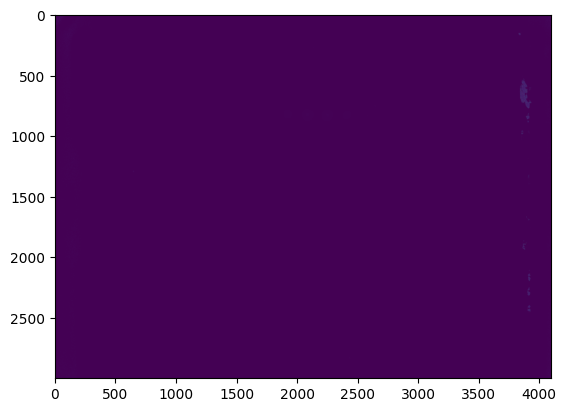

Time5: 3.5934221744537354


In [6]:
start_time = time.time()
tif_paths = glob.glob("signal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
raw_images = []
for i in range(len(tif_paths)):
	raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
	raw_images.append(raw_img)
raw_images = np.array(raw_images).astype(int)
weights = w(raw_images)
g_vals = g[raw_images]
log_exp = np.log(expos)[:, None]
num = np.sum(weights * (g_vals - log_exp), axis=0)
den = np.sum(weights, axis=0)
HDR_img = np.exp(num / den)
HDR_img = HDR_img * (2**12)
HDR_pic = HDR_img.reshape((3000, 4096))
HDR_pic = HDR_pic.round().astype(np.uint16)
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M")
HDR_pic1.save(f"HDR{timestamp_str}.tif")
print(f"Time5: {time.time() - start_time}")

In [4]:
start_time = time.time()
tif_paths = glob.glob("Optimal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
Z, B, raw_imgs = pixelValues(tif_paths, expos, 300000)
#for i in range(Z.shape[0]):
#	plt.plot(np.log(expos), Z[i, :])	
#plt.show()
new_Z = Z[Z[:, 0] < 65000]
new_Z = new_Z[new_Z[:, 0] > 1.6*new_Z[:, 1]]
#for i in range(new_Z.shape[0]):
#	plt.plot(np.log(expos), new_Z[i, :])	
#plt.show()


Time2: 160.11714100837708


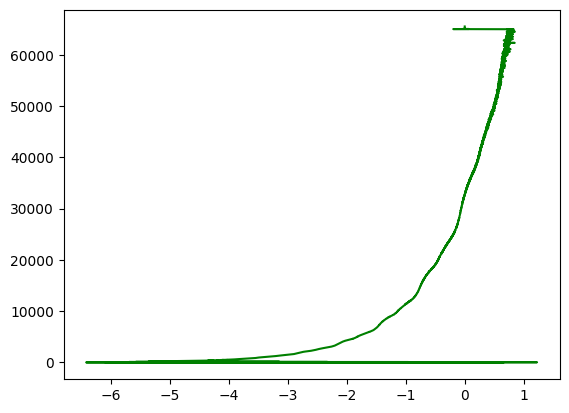

Value of g at 32767 is: 9.041476660588849e-05


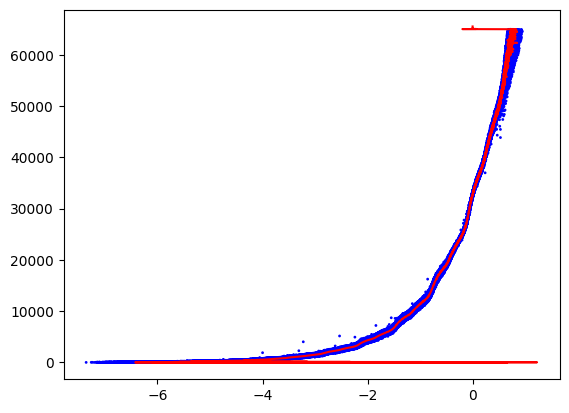

Time3: 175.0393087863922
Time4: 176.5755434036255


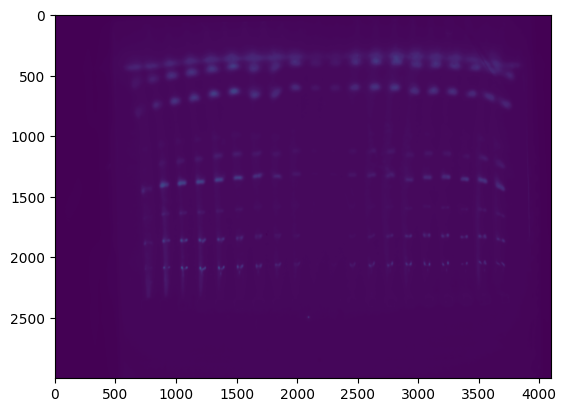

Time5: 178.16742491722107


In [5]:
g, lE, x = gsolve_cusp(new_Z, B, 2.5, w)
print(f"Time2: {time.time() - start_time}")
plt.plot(g, np.arange(65536), 'g')
plt.show()
print(f"Value of g at 32767 is: {g[32767]}")

lE_t_dt = np.zeros_like(new_Z)
for i in range(new_Z.shape[1]):
	lE_t_dt [:, i] = expos[i]*np.exp(lE)

plt.scatter(np.log(lE_t_dt.flatten()), new_Z.flatten(), s=1, marker = "o",facecolors='none', edgecolors='blue')
plt.plot(g, np.arange(65536), 'r')
plt.show()
print(f"Time3: {time.time() - start_time}")
# HDR_img = np.zeros((len(raw_imgs[0]), 1), dtype=np.float32)
# num = 0;	den = 0

weights = w(raw_imgs)
g_vals = g[raw_imgs]
log_exp = np.log(expos)[:, None]
num = np.sum(weights * (g_vals - log_exp), axis=0)
den = np.sum(weights, axis=0)
HDR_img = np.exp(num / den)

print(f"Time4: {time.time() - start_time}")
HDR_img = HDR_img * (2**12)
HDR_pic = HDR_img.reshape((3000, 4096))
HDR_pic = HDR_pic.round().astype(np.uint16)
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M")
HDR_pic1.save(f"HDR{timestamp_str}.tif")
print(f"Time5: {time.time() - start_time}")

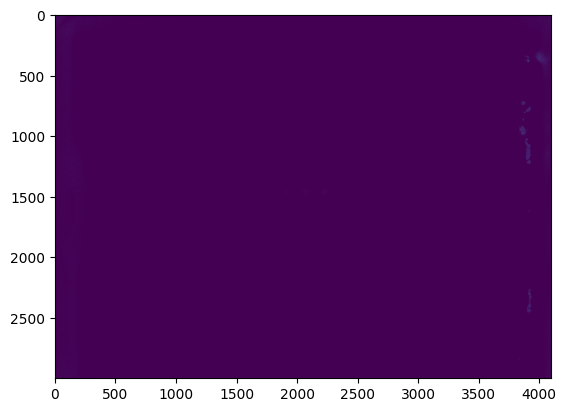

In [ ]:
# Rev = '251116-01'
# np.save('CRF.npy', g)
from PIL import Image
import numpy as np
import random, glob, time, cupy, os
from matplotlib import pyplot as plt
import cupyx.scipy.sparse as cusp
import scipy.sparse as sp
import cupyx.scipy.sparse.linalg as cusplin
from datetime import datetime

Rev = '251116-01'

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives maximum weightage to the pixel values in the middle than the extreme ones
    """
    # return (Z/32767) if Z <= 32767 else ((65535-Z)/32767)
    return np.where(Z <= 32767, Z/32767, ((65535 - Z)/32767))

tif_paths = glob.glob("Images/*.tif")
tif_paths.sort(key=os.path.getmtime)
images = []
acquisitions = [6, 7, 8, 9, 10, 11, 30, 31, 32, 33, 34, 35]
images = [np.asarray(Image.open(x), dtype=np.float32) for x in tif_paths]
for i in range(int(len(acquisitions)/2)):
    avg_blank_img = (images[acquisitions[i]] + images[acquisitions[i]+6]
                   + images[acquisitions[i]+12] + images[acquisitions[i]+18])/4
    avg_sig_img = (images[acquisitions[i+6]] + images[acquisitions[i+6]+6]
                   + images[acquisitions[i+6]+12] + images[acquisitions[i+6]+18])/4
    blank_substracted = avg_sig_img - avg_blank_img
    blank_substracted = np.array(blank_substracted)
    blank_substracted[blank_substracted < 1] = 1
    blank_substracted = blank_substracted.round().astype(np.uint16)
    savefile = Image.fromarray(blank_substracted)
    fname = "signal_"+str(i)+'.tif'
    savefile.save(fname)

# start_time = time.time()
tif_paths = glob.glob("signal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]
# Z, B, raw_imgs = pixelValues(tif_paths, expos, 30000)
# print(f"Time1: {time.time() - start_time}")

# print(f"Time2: {time.time() - start_time}")
# print(f"Time3: {time.time() - start_time}")
# HDR_img = np.zeros((len(raw_imgs[0]), 1), dtype=np.float32)
# num = 0;	den = 0
raw_images = []
for i in range(len(tif_paths)):
	raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
	raw_images.append(raw_img)
raw_images = np.array(raw_images).astype(int)
g = np.load('CRF.npy')
weights = w(raw_images)
g_vals = g[raw_images]
log_exp = np.log(expos)[:, None]
num = np.sum(weights * (g_vals - log_exp), axis=0)
den = np.sum(weights, axis=0)
HDR_img = np.exp(num / den)
HDR_img = HDR_img * (2**12)
HDR_pic = HDR_img.reshape((3000, 4096))
HDR_pic = HDR_pic.round().astype(np.uint16)
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M")
HDR_pic1.save(f"HDR_NB{Rev}_{timestamp_str}.tif")
# print(f"Time5: {time.time() - start_time}")

### How does g vary with pixel value? 
At high pixel values, it beomes 0 and
at low pixel values, it oscillates between 

1.227308089601454
41


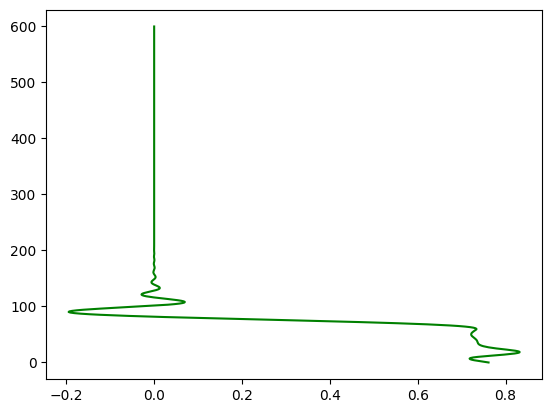

In [ ]:
print(np.max(g))
print(np.argmax(g))
plt.plot(g[64936:65536], np.arange(600), 'g')
plt.plot(g[0:600], np.arange(600), 'r')
plt.show()
np.savetxt('CRF.csv',g,delimiter=',')

## HDR Revision = 251117-01

C:\Users\Chetan Hire\AppData\Local\Temp\ipykernel_32664\2020855153.py:58: RuntimeWarning: invalid value encountered in divide
  HDR_img = np.exp(num / den)
C:\Users\Chetan Hire\AppData\Local\Temp\ipykernel_32664\2020855153.py:61: RuntimeWarning: invalid value encountered in cast
  HDR_pic = HDR_pic.round().astype(np.uint16)


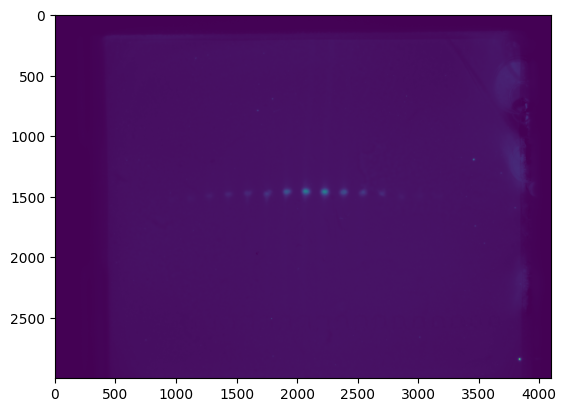

In [1]:
# Rev = '251117-01'
from PIL import Image
import numpy as np
import random, glob, time, cupy, os
from matplotlib import pyplot as plt
import cupyx.scipy.sparse as cusp
import scipy.sparse as sp
import cupyx.scipy.sparse.linalg as cusplin
from datetime import datetime

Rev = '251117-01'

def w(Z):
    """ 
    This is the weight function for the pixel value
    It gives maximum weightage to the pixel values in the middle than the extreme ones
    """
    # return np.where((Z < 250 or Z > (65536 - 600)), 0, 1 - ((abs(32767 - Z))/32767))
    return np.where((Z < 250) | (Z > (65536 - 600)), 0, 1 - (np.abs(32767 - Z) / 32767))
	
tif_paths = glob.glob("Images/*.tif")
tif_paths.sort(key=os.path.getmtime)
images = []
acquisitions = [6, 7, 8, 9, 10, 11, 30, 31, 32, 33, 34, 35]
images = [np.asarray(Image.open(x), dtype=np.float32) for x in tif_paths]
for i in range(int(len(acquisitions)/2)):
    avg_blank_img = (images[acquisitions[i]] + images[acquisitions[i]+6]
                   + images[acquisitions[i]+12] + images[acquisitions[i]+18])/4
    avg_sig_img = (images[acquisitions[i+6]] + images[acquisitions[i+6]+6]
                   + images[acquisitions[i+6]+12] + images[acquisitions[i+6]+18])/4
    blank_substracted = avg_sig_img - avg_blank_img
    blank_substracted = np.array(blank_substracted)
    blank_substracted[blank_substracted < 1] = 1
    blank_substracted = blank_substracted.round().astype(np.uint16)
    savefile = Image.fromarray(blank_substracted)
    fname = "signal_"+str(i)+'.tif'
    savefile.save(fname)

# start_time = time.time()
tif_paths = glob.glob("signal*.tif")
expos = [7.272, 3.636, 1.818, 0.909, 0.455, 0.228]

# print(f"Time1: {time.time() - start_time}")
# print(f"Time2: {time.time() - start_time}")
# print(f"Time3: {time.time() - start_time}")

raw_images = []
for i in range(len(tif_paths)):
	raw_img = np.asarray(Image.open(tif_paths[i]), dtype = np.float32).flatten()
	raw_images.append(raw_img)
raw_images = np.array(raw_images).astype(int)
g = np.load('CRF.npy')
weights = w(raw_images)
g_vals = g[raw_images]
log_exp = np.log(expos)[:, None]
num = np.sum(weights * (g_vals - log_exp), axis=0)
den = np.sum(weights, axis=0)
HDR_img = np.exp(num / den)
HDR_img = HDR_img * (2**6) * 100
HDR_pic = HDR_img.reshape((3000, 4096))
HDR_pic = HDR_pic.round().astype(np.uint16)
plt.imshow(HDR_pic)
plt.show()
HDR_pic1 = Image.fromarray(HDR_pic)
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M")
HDR_pic1.save(f"HDR_NB{Rev}_{timestamp_str}.tif")